In [6]:
# Import some basic libraries and functions for this tutorial.
import numpy as np
import os

from pydrake.common import temp_directory
from pydrake.geometry import SceneGraphConfig, StartMeshcat
from pydrake.math import RigidTransform, RollPitchYaw
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder, LeafSystem
from pydrake.visualization import AddDefaultVisualization, ModelVisualizer

import numpy
import pydrake.geometry
import pydrake.math
import pydrake.multibody.plant
import pydrake.multibody.tree
import pydrake.systems.framework
import pydrake.systems.primitives
from pydrake.math import RigidTransform as RigidTransform, RollPitchYaw as RollPitchYaw
from typing import Any, Callable, ClassVar, overload

from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    ContactVisualizer,
    DiagramBuilder,
    ExternallyAppliedSpatialForce,
    LeafSystem,
    List,
    MeshcatVisualizer,
    VectorLogSink,
    ModelVisualizer,
    Parser,
    Simulator,
    SpatialForce,
    StartMeshcat,
    Value,
    SceneGraphConfig,
)

from manipulation import ConfigureParser, FindResource, running_as_notebook
import pydrake
import ast
import pandas as pd
import utils

In [2]:
# Start the visualizer. The cell will output an HTTP link after the execution.
# Click the link and a MeshCat tab should appear in your browser.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [64]:
# Define a simple cylinder model.

def create_cylinder_sdf(mass=1.0, inertia=[0.005833, 0.0, 0.0, 0.005833, 0.0, 0.005], radius=0.1, length=0.2, color=[1.0, 1.0, 1.0, 1.0]):
  cylinder_sdf = f"""<?xml version="1.0"?>
  <sdf version="1.7">
    <model name="cylinder">
      <pose>0 0 0 0 0 0</pose>
      <link name="cylinder_link">
        <inertial>
          <mass>{mass}</mass>
          <inertia>
            <ixx>{inertia[0]}</ixx>
            <ixy>{inertia[1]}</ixy>
            <ixz>{inertia[2]}</ixz>
            <iyy>{inertia[3]}</iyy>
            <iyz>{inertia[4]}</iyz>
            <izz>{inertia[5]}</izz>
          </inertia>
        </inertial>
        <collision name="collision">
          <geometry>
            <cylinder>
              <radius>{radius}</radius>
              <length>{length}</length>
            </cylinder>
          </geometry>
        </collision>
        <visual name="visual">
          <geometry>
            <cylinder>
              <radius>{radius}</radius>
              <length>{length}</length>
            </cylinder>
          </geometry>
          <material>
            <diffuse>{' '.join(map(str, color))}</diffuse>
          </material>
        </visual>
      </link>
    </model>
  </sdf>
  """
  return cylinder_sdf

cylinder_sdf = create_cylinder_sdf(radius=0.01)

def create_box_sdf(mass=1.0, inertia=None, size=[0.1, 0.1, 0.1], color=[1.0, 1.0, 1.0, 1.0]):  
    if inertia is None:  
        inertia = [0.01, 0.0, 0.0, 0.01, 0.0, 0.01]  # Default inertia for a box  

    box_sdf = f"""<?xml version="1.0"?>  
    <sdf version="1.7">  
        <model name="box">  
            <pose>0 0 0 0 0 0</pose>  
            <link name="box_link">  
                <inertial>  
                    <mass>{mass}</mass>  
                    <inertia>  
                        <ixx>{inertia[0]}</ixx>  
                        <ixy>{inertia[1]}</ixy>  
                        <ixz>{inertia[2]}</ixz>  
                        <iyy>{inertia[3]}</iyy>  
                        <iyz>{inertia[4]}</iyz>  
                        <izz>{inertia[5]}</izz>  
                    </inertia>  
                </inertial>  
                <collision name="collision">  
                    <geometry>  
                        <box>  
                            <size>{' '.join(map(str, size))}</size>  
                        </box>  
                    </geometry>  
                </collision>  
                <visual name="visual">  
                    <geometry>  
                        <box>  
                            <size>{' '.join(map(str, size))}</size>  
                        </box>  
                    </geometry>  
                    <material>  
                        <diffuse>{' '.join(map(str, color))}</diffuse>  
                    </material>  
                </visual>  
            </link>  
        </model>  
    </sdf>  
    """  
    return box_sdf

box_sdf = create_box_sdf(size=[0.05, 0.05, 0.05])

# Create a Drake temporary directory to store files.
# Note: this tutorial will create a temporary file (table_top.sdf)
# in the `/tmp/robotlocomotion_drake_xxxxxx` directory.
temp_dir = temp_directory()

# Create a table top SDFormat model.
table_top_sdf_file = os.path.join(temp_dir, "table_top.sdf")
table_top_sdf = """<?xml version="1.0"?>
<sdf version="1.7">
  <model name="table_top">
    <link name="table_top_link">
      <visual name="visual">
        <pose>0 0 0.445 0 0 0</pose>
        <geometry>
          <box>
            <size>0.55 1.1 0.05</size>
          </box>
        </geometry>
        <material>
         <diffuse>0.9 0.8 0.7 1.0</diffuse>
        </material>
      </visual>
      <collision name="collision">
        <pose>0 0 0.445  0 0 0</pose>
        <geometry>
          <box>
            <size>0.55 1.1 0.05</size>
          </box>
        </geometry>
      </collision>
    </link>
    <frame name="table_top_center">
      <pose relative_to="table_top_link">0 0 0.47 0 0 0</pose>
    </frame>
  </model>
</sdf>

"""

with open(table_top_sdf_file, "w") as f:
    f.write(table_top_sdf)

def initialize_simulation(diagram):
    simulator = Simulator(diagram)
    simulator.Initialize()
    # simulator.set_target_realtime_rate(1.0)
    return simulator

meshcat.Delete()
meshcat.DeleteAddedControls()



def contact_simulation(compliance_type="compliant", 
                       hydroelastic_modulus=1e7, 
                       point_stiffness=1e6,
                       mass=1.0):
  builder = DiagramBuilder()
  plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.001)
  scene_graph_config = SceneGraphConfig()
  # properties = 
  # pydrake.geometry.AddContactMaterial(point_stiffness=point_stiffness,properties=properties)
  scene_graph_config.default_proximity_properties.compliance_type = compliance_type
  scene_graph_config.default_proximity_properties.hydroelastic_modulus = hydroelastic_modulus
  scene_graph_config.default_proximity_properties.point_stiffness = point_stiffness
  # scene_graph_config.default_proximity_properties
  scene_graph.set_config(scene_graph_config)

  parser = Parser(plant)
  ConfigureParser(parser)
  # parser.AddModelsFromString(cylinder_sdf, "sdf")
  box_sdf = create_box_sdf(size=[0.05, 0.05, 0.05], mass=mass)
  parser.AddModelsFromString(box_sdf, "sdf")
  parser.AddModels(table_top_sdf_file)
  # Weld the table to the world so that it's fixed during the simulation.
  table_frame = plant.GetFrameByName("table_top_center")
  plant.WeldFrames(plant.world_frame(), table_frame)
  # Finalize the plant after loading the scene.
  # plant.set_contact_model(ContactModel.kFrictionless)
  # plant.set_penetration_allowance(0.01)

  plant.Finalize()
  plant_context = plant.CreateDefaultContext()
  # plant.get_contact_penalty_method_time_scale()

  # Set the initial pose for the free bodies, i.e., the custom cylinder,
  box = plant.GetBodyByName("box_link")
  X_WorldTable = table_frame.CalcPoseInWorld(plant_context)
  X_Tablebox = RigidTransform(
      RollPitchYaw(np.asarray([0, 0, 0]) * np.pi / 180), p=[0,0,0.5])
  X_Worldbox = X_WorldTable.multiply(X_Tablebox)
  plant.SetDefaultFreeBodyPose(box, X_Worldbox)

  # visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
  # ContactVisualizer.AddToBuilder(builder, plant, meshcat)

  # pusher = builder.AddSystem(CylinderPusher())
  logger = builder.AddSystem(VectorLogSink(13))

  # builder.Connect(pusher.get_output_port(), 
  #                 plant.get_applied_spatial_force_input_port())

  # builder.Connect(pusher.cylinder_pos_input, 
  #                 plant.get_state_output_port(plant.GetModelInstanceByName("cylinder")))
  builder.Connect(plant.get_state_output_port(plant.GetModelInstanceByName("box")),
                  logger.get_input_port(0))

  diagram = builder.Build()


  simulator = initialize_simulation(diagram)
  context = simulator.get_mutable_context()

  # meshcat.StartRecording()
  finish_time = 5
  simulator.AdvanceTo(finish_time)
  # meshcat.PublishRecording()
  q0 = plant.GetPositions(plant_context, plant.GetModelInstanceByName("box"))
  # print("q0: ", q0)

  time = logger.FindLog(context).sample_times()
  traj = logger.FindLog(context).data()
  return time, traj[6,:]

time, traj = contact_simulation()

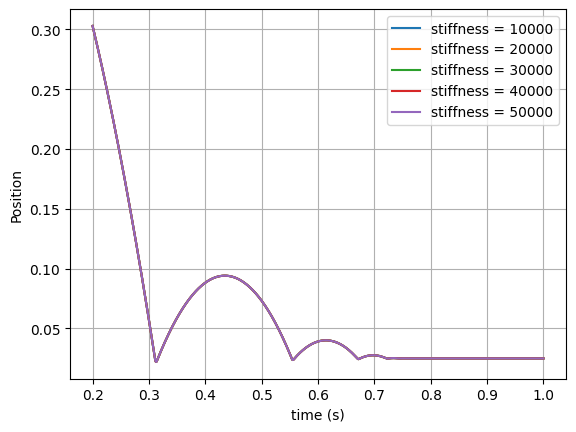

In [62]:
import matplotlib.pyplot as plt

start_time = 0.2  # seconds  
end_time = 1    # seconds  
point_stiffness_list = [10000, 20000, 30000, 40000, 50000]
plt.figure()
for point_stiffness in point_stiffness_list:
    time, traj = contact_simulation(point_stiffness=point_stiffness)
    mask = (time >= start_time) & (time <= end_time)  
    plt.plot(time[mask], traj[mask], label=f'stiffness = {point_stiffness}')  
plt.legend()  
plt.grid()  
plt.xlabel("time (s)")  
plt.ylabel("Position")  
plt.show()  

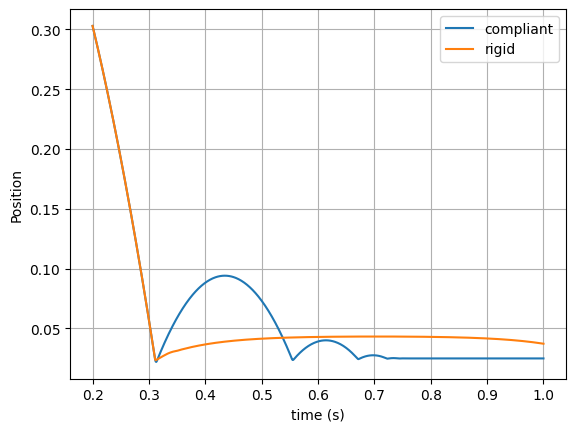

In [64]:
import matplotlib.pyplot as plt

start_time = 0.2  # seconds  
end_time = 1    # seconds  
compliance_type_list = ['compliant', 'rigid']
plt.figure()
for compliance_type in compliance_type_list:
    time, traj = contact_simulation(compliance_type=compliance_type)
    mask = (time >= start_time) & (time <= end_time)  
    plt.plot(time[mask], traj[mask], label=f'{compliance_type}')  
plt.legend()
plt.grid()
plt.xlabel("time (s)")
plt.ylabel("Position")
plt.show()  

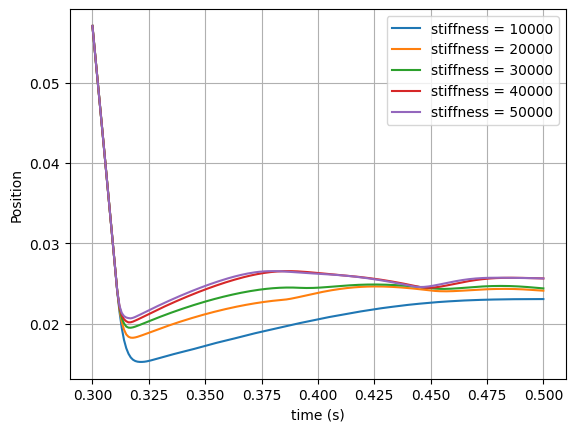

In [67]:
import matplotlib.pyplot as plt

start_time = 0.3 # seconds  
end_time = 0.5    # seconds  
point_stiffness_list = [10000, 20000, 30000, 40000, 50000]
plt.figure()
for point_stiffness in point_stiffness_list:
    time, traj = contact_simulation(point_stiffness=point_stiffness, compliance_type='rigid')
    mask = (time >= start_time) & (time <= end_time)  
    plt.plot(time[mask], traj[mask], label=f'stiffness = {point_stiffness}')  
plt.legend()  
plt.grid()  
plt.xlabel("time (s)")  
plt.ylabel("Position")  
plt.show()  

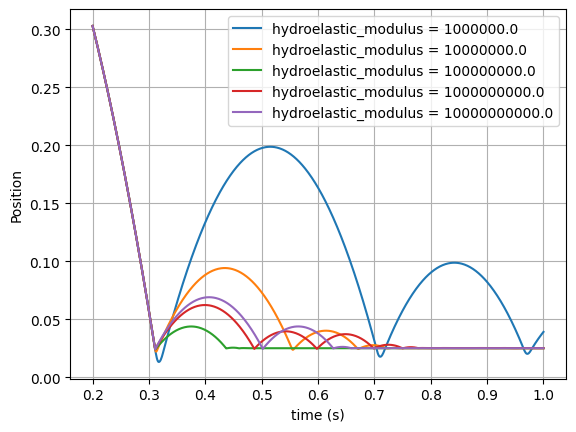

In [69]:
import matplotlib.pyplot as plt

start_time = 0.2  # seconds  
end_time = 1    # seconds  
hydroelastic_modulus_list = [1e6, 1e7, 1e8, 1e9, 1e10]
plt.figure()
for hydroelastic_modulus in hydroelastic_modulus_list:
    time, traj = contact_simulation(hydroelastic_modulus=hydroelastic_modulus)
    mask = (time >= start_time) & (time <= end_time)  
    plt.plot(time[mask], traj[mask], label=f'hydroelastic_modulus = {hydroelastic_modulus}')  
plt.legend()  
plt.grid()  
plt.xlabel("time (s)")  
plt.ylabel("Position")  
plt.show()

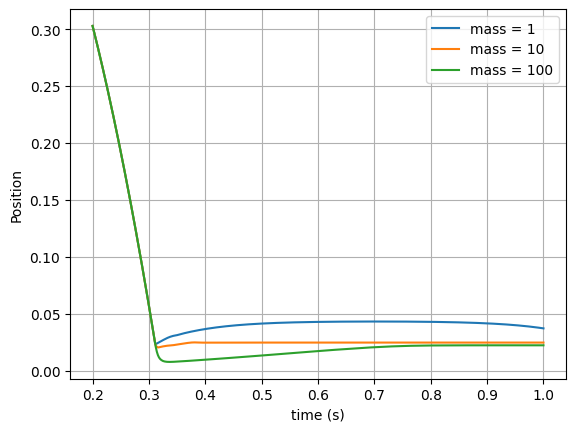

In [67]:
import matplotlib.pyplot as plt

start_time = 0.2  # seconds  
end_time = 1    # seconds  
mass_list = [1, 10, 100]
plt.figure()
for mass in mass_list:
    time, traj = contact_simulation(mass=mass, compliance_type='rigid')
    mask = (time >= start_time) & (time <= end_time)  
    plt.plot(time[mask], traj[mask], label=f'mass = {mass}')  
plt.legend()  
plt.grid()  
plt.xlabel("time (s)")  
plt.ylabel("Position")  
plt.show()

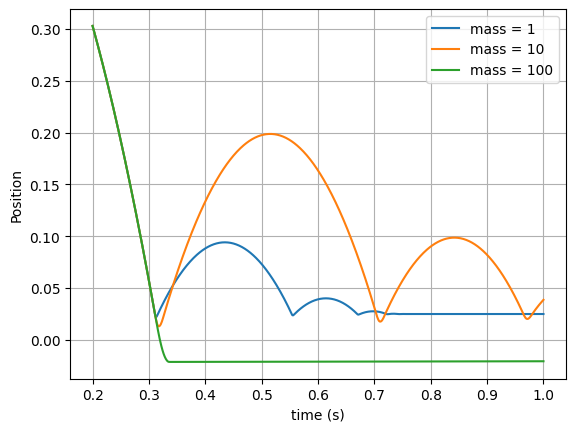

In [68]:
import matplotlib.pyplot as plt

start_time = 0.2  # seconds  
end_time = 1    # seconds  
mass_list = [1, 10, 100]
plt.figure()
for mass in mass_list:
    time, traj = contact_simulation(mass=mass, compliance_type='compliant')
    mask = (time >= start_time) & (time <= end_time)  
    plt.plot(time[mask], traj[mask], label=f'mass = {mass}')  
plt.legend()  
plt.grid()  
plt.xlabel("time (s)")  
plt.ylabel("Position")  
plt.show()

Text(0.5, 0, 'time (s)')

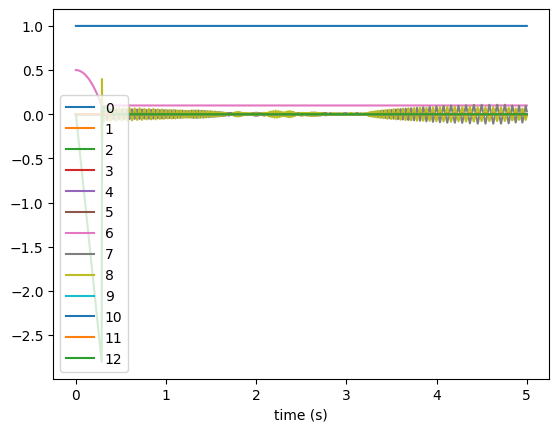

In [6]:
import matplotlib.pyplot as plt
time = logger.FindLog(context).sample_times()
traj = logger.FindLog(context).data()

plt.figure()
for i in range(traj.shape[0]):
    plt.plot(time, traj[i, :], label=str(i))
plt.legend()
plt.xlabel("time (s)")
# plt.ylabel("q (rads)")



Text(0.5, 0, 'time (s)')

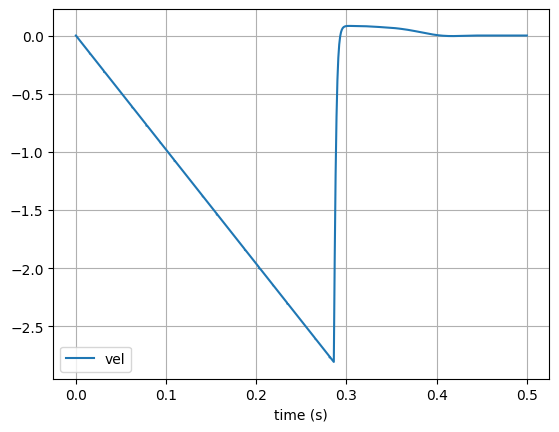

In [24]:
start_time = 0  # seconds  
end_time = 0.5    # seconds  
mask = (time >= start_time) & (time <= end_time)  

plt.figure()
plt.plot(time[mask], traj[12, mask], label='vel')
plt.legend()
plt.grid()
plt.xlabel("time (s)")

In [15]:
plant.num_multibody_states()
plant.num_force_elements()

1

In [ ]:
import pydot
from IPython.display import SVG, display


display(SVG(pydot.graph_from_dot_data(
    diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

## force related to the position of cylinder

In [10]:
meshcat.Delete()
meshcat.DeleteAddedControls()


builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.001)
parser = Parser(plant)
ConfigureParser(parser)
parser.AddModelsFromString(cylinder_sdf, "sdf")
parser.AddModels(table_top_sdf_file)
# Weld the table to the world so that it's fixed during the simulation.
table_frame = plant.GetFrameByName("table_top_center")
plant.WeldFrames(plant.world_frame(), table_frame)
# Finalize the plant after loading the scene.
plant.Finalize()
plant_context = plant.CreateDefaultContext()

# Set the initial pose for the free bodies, i.e., the custom cylinder,
cylinder = plant.GetBodyByName("cylinder_link")
X_WorldTable = table_frame.CalcPoseInWorld(plant_context)
X_TableCylinder = RigidTransform(
    RollPitchYaw(np.asarray([0, 0, 0]) * np.pi / 180), p=[0,0,0.5])
X_WorldCylinder = X_WorldTable.multiply(X_TableCylinder)
plant.SetDefaultFreeBodyPose(cylinder, X_WorldCylinder)

visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
ContactVisualizer.AddToBuilder(builder, plant, meshcat)

class CylinderPusher(LeafSystem):
    def __init__(self):
        LeafSystem.__init__(self)
        forces_cls = Value[List[ExternallyAppliedSpatialForce]]
        self.DeclareAbstractOutputPort(
            "applied_force", lambda: forces_cls(), self.CalcOutput
        )
        self.DeclareVectorInputPort(name="cylinder_pos", size=13)

    def CalcOutput(self, context, output):
        cylinder_current_state = self.get_input_port(0).Eval(context)
        cylinder_current_z = cylinder_current_state[6]
        delta_z = 0.5 - cylinder_current_z
        cylinder_current_vel_z = cylinder_current_state[12]
        k = 100
        b = 1

        forces = []
        force = ExternallyAppliedSpatialForce()
        force.body_index = plant.GetBodyByName(f"cylinder_link").index()
        force.p_BoBq_B = np.array([0,0,0])  # world 0, 0, 0
        # force.p_BoBq_B = cylinder.CalcCenterOfMassInBodyFrame(plant_context)    # pos in body frame 0 0 0
        # print(force.p_BoBq_B)
        force.F_Bq_W = SpatialForce(
            tau=np.array([0,0,0]),
            f=[0, 0, k*delta_z - b*cylinder_current_vel_z],
        )
        forces.append(force)
        output.set_value(forces)

pusher = builder.AddSystem(CylinderPusher())


logger = builder.AddSystem(VectorLogSink(13))

builder.Connect(pusher.get_output_port(), 
                plant.get_applied_spatial_force_input_port())

builder.Connect(plant.get_state_output_port(plant.GetModelInstanceByName("cylinder")),pusher.get_input_port(0))

builder.Connect(plant.get_state_output_port(plant.GetModelInstanceByName("cylinder")),
                logger.get_input_port(0))

diagram = builder.Build()


simulator = initialize_simulation(diagram)
context = simulator.get_mutable_context()

meshcat.StartRecording()
finish_time = 5
simulator.AdvanceTo(finish_time)
meshcat.PublishRecording()
q0 = plant.GetPositions(plant_context, plant.GetModelInstanceByName("cylinder"))
print("q0: ", q0)

q0:  [1. 0. 0. 0. 0. 0. 0.]


## 两个弹簧连接，重构函数

In [3]:
import importlib
importlib.reload(utils)
import utils

meshcat.Delete()
meshcat.DeleteAddedControls()

def create_scene(sim_time_step=0.001):
    
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=sim_time_step)

    bar_sdf_1 = utils.create_bar_sdf(pose=[-0.1, 0, 0.5, 0, 0, 0],
                                     color=[1.0, 0.0, 0.0, 0.5],
                                     radius=0.01,
                                     name="bar_1")
    bar_sdf_2 = utils.create_bar_sdf(pose=[0.1, 0, 0.5, 0, 0, 0],
                                     color=[0.0, 1.0, 0.0, 0.5],
                                     radius=0.01,
                                     name="bar_2")
    floor_sdf = utils.create_floor_sdf()
    parser = Parser(plant)
    parser.AddModelsFromString(bar_sdf_1, "sdf")
    parser.AddModelsFromString(bar_sdf_2, "sdf")
    parser.AddModelsFromString(floor_sdf, "sdf")

    # Weld the table to the world so that it's fixed during the simulation.
    table_frame = plant.GetFrameByName("table_top_center")
    plant.WeldFrames(plant.world_frame(), table_frame)

    bar_1_model = plant.GetModelInstanceByName("bar_1")
    plant.set_gravity_enabled(bar_1_model,is_enabled=False)
    bar_2_model = plant.GetModelInstanceByName("bar_2")
    plant.set_gravity_enabled(bar_2_model,is_enabled=False)

    # Finalize the plant after loading the scene.
    plant.Finalize()
    plant_context = plant.CreateDefaultContext()

    # Set the initial pose for the free bodies, i.e., the custom Bar_1,
    bar_1_link = plant.GetBodyByName("bar_1_link")
    X_WorldTable = table_frame.CalcPoseInWorld(plant_context)
    X_TableBar_1 = RigidTransform(
        RollPitchYaw(np.asarray([0, 0, 0]) * np.pi / 180), p=[0.5,0,0.5])
    X_WorldBar_1 = X_WorldTable.multiply(X_TableBar_1)
    plant.SetDefaultFreeBodyPose(bar_1_link, X_WorldBar_1)

    bar_2_link = plant.GetBodyByName("bar_2_link")
    X_WorldTable = table_frame.CalcPoseInWorld(plant_context)
    X_TableBar_2 = RigidTransform(
        RollPitchYaw(np.asarray([0, 0, 0]) * np.pi / 180), p=[-0.5,0,0.5])
    X_WorldBar_2 = X_WorldTable.multiply(X_TableBar_2)
    plant.SetDefaultFreeBodyPose(bar_2_link, X_WorldBar_2)

    

    spring = builder.AddSystem(utils.Spring(plant, stiffness=100, damping=1))

    logger = builder.AddSystem(VectorLogSink(13))

    builder.Connect(spring.get_output_port(), 
                    plant.get_applied_spatial_force_input_port())

    builder.Connect(plant.get_state_output_port(plant.GetModelInstanceByName("bar_1")), 
                    spring.get_input_port(0))
    
    builder.Connect(plant.get_state_output_port(plant.GetModelInstanceByName("bar_2")), 
                    spring.get_input_port(1))

    builder.Connect(plant.get_state_output_port(plant.GetModelInstanceByName("bar_1")),
                    logger.get_input_port(0))

    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    ContactVisualizer.AddToBuilder(builder, plant, meshcat)
    diagram = builder.Build()
    diagram.set_name("two_bar_diagram")
    return diagram

diagram = create_scene()
simulator = utils.run_simulation(diagram,
                                meshcat,
                                finish_time=5)

<class 'pydrake.multibody.plant.ExternallyAppliedSpatialForce'>


In [ ]:
import importlib
importlib.reload(utils)
import utils

meshcat.Delete()
meshcat.DeleteAddedControls()

def create_scene(sim_time_step=0.001):
    
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=sim_time_step)

    bar_sdf_1 = utils.create_bar_sdf(pose=[-0.1, 0, 0.5, 0, 0, 0],
                                     color=[1.0, 0.0, 0.0, 0.5],
                                     radius=0.01,
                                     name="bar_1")
    bar_sdf_2 = utils.create_bar_sdf(pose=[0.1, 0, 0.5, 0, 0, 0],
                                     color=[0.0, 1.0, 0.0, 0.5],
                                     radius=0.01,
                                     name="bar_2")
    floor_sdf = utils.create_floor_sdf()
    parser = Parser(plant)
    parser.AddModelsFromString(bar_sdf_1, "sdf")
    parser.AddModelsFromString(bar_sdf_2, "sdf")
    parser.AddModelsFromString(floor_sdf, "sdf")

    # Weld the table to the world so that it's fixed during the simulation.
    table_frame = plant.GetFrameByName("table_top_center")
    plant.WeldFrames(plant.world_frame(), table_frame)

    bar_1_model = plant.GetModelInstanceByName("bar_1")
    plant.set_gravity_enabled(bar_1_model,is_enabled=False)
    bar_2_model = plant.GetModelInstanceByName("bar_2")
    plant.set_gravity_enabled(bar_2_model,is_enabled=False)

    # Finalize the plant after loading the scene.
    plant.Finalize()
    plant_context = plant.CreateDefaultContext()

    # Set the initial pose for the free bodies, i.e., the custom Bar_1,
    bar_1_link = plant.GetBodyByName("bar_1_link")
    X_WorldTable = table_frame.CalcPoseInWorld(plant_context)
    X_TableBar_1 = RigidTransform(
        RollPitchYaw(np.asarray([0, 0, 0]) * np.pi / 180), p=[0.5,0,0.5])
    X_WorldBar_1 = X_WorldTable.multiply(X_TableBar_1)
    plant.SetDefaultFreeBodyPose(bar_1_link, X_WorldBar_1)

    bar_2_link = plant.GetBodyByName("bar_2_link")
    X_WorldTable = table_frame.CalcPoseInWorld(plant_context)
    X_TableBar_2 = RigidTransform(
        RollPitchYaw(np.asarray([0, 0, 0]) * np.pi / 180), p=[-0.5,0,0.5])
    X_WorldBar_2 = X_WorldTable.multiply(X_TableBar_2)
    plant.SetDefaultFreeBodyPose(bar_2_link, X_WorldBar_2)

    
    
    spring = builder.AddSystem(utils.Spring(plant, stiffness=100, damping=1))

    logger = builder.AddSystem(VectorLogSink(13))

    builder.Connect(spring.get_output_port(), 
                    plant.get_applied_spatial_force_input_port())

    builder.Connect(plant.get_state_output_port(plant.GetModelInstanceByName("bar_1")), 
                    spring.get_input_port(0))
    
    builder.Connect(plant.get_state_output_port(plant.GetModelInstanceByName("bar_2")), 
                    spring.get_input_port(1))

    builder.Connect(plant.get_state_output_port(plant.GetModelInstanceByName("bar_1")),
                    logger.get_input_port(0))

    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    ContactVisualizer.AddToBuilder(builder, plant, meshcat)
    diagram = builder.Build()
    diagram.set_name("two_bar_diagram")
    return diagram

diagram = create_scene()
simulator = utils.run_simulation(diagram,
                                meshcat,
                                finish_time=5)

In [15]:
import importlib
importlib.reload(utils)
import utils

meshcat.Delete()
meshcat.DeleteAddedControls()

def create_scene(sim_time_step=0.001):
    
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=sim_time_step)

    bar_sdf_1 = utils.create_bar_sdf(pose=[-0.1, 0, 0.5, 0, 0, 0],
                                     color=[1.0, 0.0, 0.0, 0.5],
                                     radius=0.01,
                                     name="bar_1")
    bar_sdf_2 = utils.create_bar_sdf(pose=[0.1, 0, 0.5, 0, 0, 0],
                                     color=[0.0, 1.0, 0.0, 0.5],
                                     radius=0.01,
                                     name="bar_2")
    floor_sdf = utils.create_floor_sdf()
    parser = Parser(plant)
    parser.AddModelsFromString(bar_sdf_1, "sdf")
    parser.AddModelsFromString(bar_sdf_2, "sdf")
    parser.AddModelsFromString(floor_sdf, "sdf")

    # Weld the table to the world so that it's fixed during the simulation.
    table_frame = plant.GetFrameByName("table_top_center")
    plant.WeldFrames(plant.world_frame(), table_frame)

    bar_1_model = plant.GetModelInstanceByName("bar_1")
    plant.set_gravity_enabled(bar_1_model,is_enabled=False)
    bar_2_model = plant.GetModelInstanceByName("bar_2")
    plant.set_gravity_enabled(bar_2_model,is_enabled=False)
    bar_1_link = plant.GetBodyByName("bar_1_link")
    bar_2_link = plant.GetBodyByName("bar_2_link")
    linear_spring = pydrake.multibody.tree.LinearSpringDamper(bodyA=bar_1_link, 
                                                            bodyB=bar_2_link, 
                                                            stiffness=1000,
                                                            damping=1,
                                                            p_AP=[0, 0, 0.1],
                                                            p_BQ=[0, 0, -0.1],
                                                            free_length=0.5)
    plant.AddForceElement(linear_spring)

    # Finalize the plant after loading the scene.
    plant.Finalize()
    plant_context = plant.CreateDefaultContext()

    # Set the initial pose for the free bodies, i.e., the custom Bar_1,
    X_WorldTable = table_frame.CalcPoseInWorld(plant_context)
    X_TableBar_1 = RigidTransform(
        RollPitchYaw(np.asarray([0, 0, 0]) * np.pi / 180), p=[0.5,0,0.5])
    X_WorldBar_1 = X_WorldTable.multiply(X_TableBar_1)
    plant.SetDefaultFreeBodyPose(bar_1_link, X_WorldBar_1)

    X_WorldTable = table_frame.CalcPoseInWorld(plant_context)
    X_TableBar_2 = RigidTransform(
        RollPitchYaw(np.asarray([0, 0, 0]) * np.pi / 180), p=[-0.5,0,0.5])
    X_WorldBar_2 = X_WorldTable.multiply(X_TableBar_2)
    plant.SetDefaultFreeBodyPose(bar_2_link, X_WorldBar_2)


    logger = builder.AddSystem(VectorLogSink(13))


    builder.Connect(plant.get_state_output_port(plant.GetModelInstanceByName("bar_1")),
                    logger.get_input_port(0))

    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    ContactVisualizer.AddToBuilder(builder, plant, meshcat)
    diagram = builder.Build()
    diagram.set_name("two_bar_diagram")
    
    return diagram

diagram = create_scene()
simulator = utils.run_simulation(diagram,
                                meshcat,
                                finish_time=5)

In [49]:
import importlib
importlib.reload(utils)
import utils

meshcat.Delete()
meshcat.DeleteAddedControls()

def create_scene(sim_time_step=0.001):
    
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=sim_time_step)

    bar_sdf_1 = utils.create_bar_sdf(start_point=[0, 0, 0.1],
                                      end_point=[0.2, 0.2, 0.2],
                                     color=[1.0, 0.0, 0.0, 0.5],
                                     radius=0.01,
                                     name="bar_1")
    bar_sdf_2 = utils.create_bar_sdf(start_point=[-0.5, 0, 1],
                                      end_point=[-0.5, 0, 1.5],
                                     color=[0.0, 1.0, 0.0, 0.5],
                                     radius=0.01,
                                     name="bar_2")
    # floor_sdf = utils.create_floor_sdf()
    parser = Parser(plant)
    parser.AddModelsFromString(bar_sdf_1, "sdf")
    parser.AddModelsFromString(bar_sdf_2, "sdf")
    # parser.AddModelsFromString(floor_sdf, "sdf")

    # Weld the table to the world so that it's fixed during the simulation.
    # table_frame = plant.GetFrameByName("table_top_center")
    # plant.WeldFrames(plant.world_frame(), table_frame)

    bar_1_model = plant.GetModelInstanceByName("bar_1")
    plant.set_gravity_enabled(bar_1_model,is_enabled=False)
    bar_2_model = plant.GetModelInstanceByName("bar_2")
    plant.set_gravity_enabled(bar_2_model,is_enabled=False)
    bar_1_link = plant.GetBodyByName("bar_1_link")
    bar_2_link = plant.GetBodyByName("bar_2_link")
    linear_spring = pydrake.multibody.tree.LinearSpringDamper(bodyA=bar_1_link, 
                                                            bodyB=bar_2_link, 
                                                            stiffness=1000,
                                                            damping=1,
                                                            p_AP=[0, 0, 0.1],
                                                            p_BQ=[0, 0, -0.1],
                                                            free_length=0.5)
    # plant.AddForceElement(linear_spring)

    # Finalize the plant after loading the scene.
    plant.Finalize()
    plant_context = plant.CreateDefaultContext()

    # Set the initial pose for the free bodies, i.e., the custom Bar_1,
    # X_WorldTable = table_frame.CalcPoseInWorld(plant_context)
    # X_TableBar_1 = RigidTransform(
    #     RollPitchYaw(np.asarray([0, 0, 0]) * np.pi / 180), p=[0.5,0,0.5])
    # X_WorldBar_1 = X_WorldTable.multiply(X_TableBar_1)
    # plant.SetDefaultFreeBodyPose(bar_1_link, X_WorldBar_1)

    # X_WorldTable = table_frame.CalcPoseInWorld(plant_context)
    # X_TableBar_2 = RigidTransform(
    #     RollPitchYaw(np.asarray([0, 0, 0]) * np.pi / 180), p=[-0.5,0,0.5])
    # X_WorldBar_2 = X_WorldTable.multiply(X_TableBar_2)
    # plant.SetDefaultFreeBodyPose(bar_2_link, X_WorldBar_2)


    logger = builder.AddSystem(VectorLogSink(13))


    builder.Connect(plant.get_state_output_port(plant.GetModelInstanceByName("bar_1")),
                    logger.get_input_port(0))

    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    ContactVisualizer.AddToBuilder(builder, plant, meshcat)
    diagram = builder.Build()
    diagram.set_name("two_bar_diagram")
    
    return diagram

diagram = create_scene()
simulator = utils.run_simulation(diagram,
                                meshcat,
                                finish_time=5)

[0.66666667 0.66666667 0.33333333]
[0.1, 0.1, 0.15000000000000002, -1.2309594173407747, 0, -0.7853981633974482]
[0. 0. 1.]
[-0.5, 0.0, 1.25, 0, 0, 0]


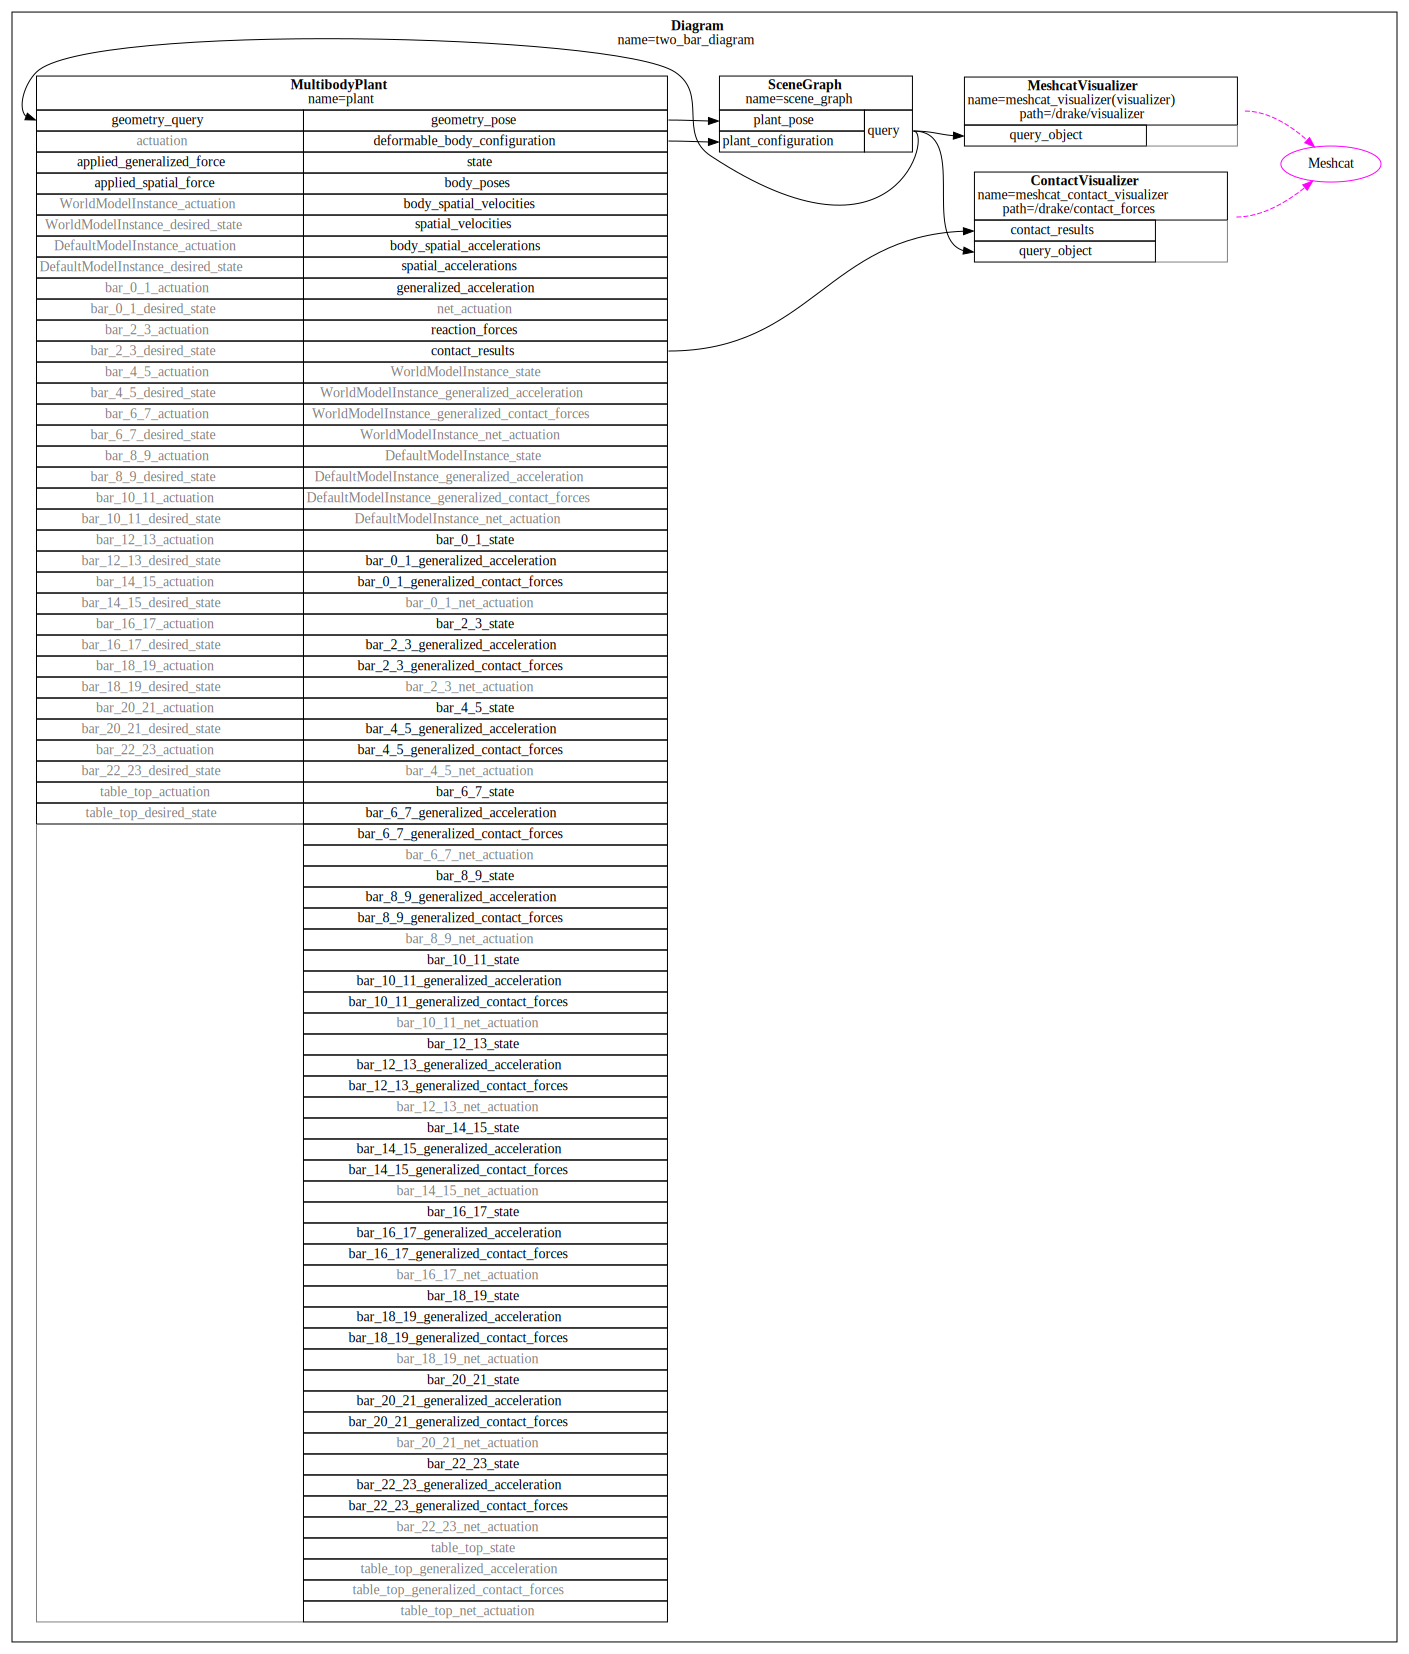

In [13]:
import pydot
from IPython.display import SVG, display


display(SVG(pydot.graph_from_dot_data(
    diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

In [9]:
# Import some basic libraries and functions for this tutorial.
import numpy as np
import os
import ast


from pydrake.common import temp_directory
from pydrake.geometry import SceneGraphConfig, StartMeshcat
from pydrake.math import RigidTransform, RollPitchYaw
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder, LeafSystem
from pydrake.visualization import AddDefaultVisualization, ModelVisualizer

import numpy
import pydrake.geometry
import pydrake.math
import pydrake.multibody.plant
import pydrake.multibody.tree
import pydrake.systems.framework
import pydrake.systems.primitives
from pydrake.math import RigidTransform as RigidTransform, RollPitchYaw as RollPitchYaw
from typing import Any, Callable, ClassVar, overload

from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    ContactVisualizer,
    DiagramBuilder,
    ExternallyAppliedSpatialForce,
    LeafSystem,
    List,
    MeshcatVisualizer,
    VectorLogSink,
    ModelVisualizer,
    Parser,
    Simulator,
    SpatialForce,
    StartMeshcat,
    Value,
    SceneGraphConfig,
)

from manipulation import ConfigureParser, FindResource, running_as_notebook
import pydrake
import utils

import pandas as pd

In [68]:
import importlib
importlib.reload(utils)
import utils

class TensegrityPlant:
    def __init__(self):
        self.num_legs = 4
        self.sim_time_step = 0.001
        self.bar_sdf_list = []
    
    def generate_tensegrity_structure(self, detailed_csv_file_path):

        builder = DiagramBuilder()
        self.plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=self.sim_time_step)

        # bar_sdf_1 = utils.create_bar_sdf(start_point=[0, 0, 0.1],
        #                                 end_point=[0.2, 0.2, 0.2],
        #                                 color=[1.0, 0.0, 0.0, 0.5],
        #                                 radius=0.01,
        #                                 name="bar_1")
        
        data = pd.read_csv(detailed_csv_file_path)
        self.node_df = data[data['Type'] == 'Node']
        self.bar_df = data[data['Type'] == 'Bar']
        self.string_df = data[data['Type'] == 'String']
        self.ball_df =  data[data['Type'] == 'Ball']

        self.parser = Parser(self.plant)
        self.generate_all_bars()
        self.generate_floor()
        self.generate_middle_platform()
        self.add_spring()
        self.add_spring2()
        

        # bar_1_model = self.plant.GetModelInstanceByName("bar_1")
        # self.plant.set_gravity_enabled(bar_1_model,is_enabled=False)

        self.plant.Finalize()
        plant_context = self.plant.CreateDefaultContext()
        MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
        ContactVisualizer.AddToBuilder(builder, self.plant, meshcat)
        diagram = builder.Build()
        diagram.set_name("two_bar_diagram")

        return diagram
    
    def find_node_coordinates(self, labels, node_df):
        node_coords = []
        for _, node_row in node_df.iterrows():
            node_data_dict = ast.literal_eval(node_row['Data'])
            node_label = node_data_dict['label']
            # print(node_label)
            if any(label == node_label for label in labels):
                node_coords.append(node_data_dict['position'])
                # print(node_coords)
        return node_coords
    
    def find_bar_name_and_alt_node_name_by_label(self, label):
        for i, row in self.bar_df.iterrows():
            data_dict = ast.literal_eval(row['Data'])
            from_node_label = data_dict['from_node_label']
            to_node_label = data_dict['to_node_label']
            alt_node_label = data_dict['alt_node_label']
            if from_node_label == label or to_node_label == label or alt_node_label == label:
                return data_dict['label'], alt_node_label
        return None, None
    
    def find_bar_name_and_alt_node_name_by_label(self, label):
        for i, row in self.bar_df.iterrows():
            data_dict = ast.literal_eval(row['Data'])
            from_node_label = data_dict['from_node_label']
            to_node_label = data_dict['to_node_label']
            alt_node_label = data_dict['alt_node_label']
            if from_node_label == label or to_node_label == label or alt_node_label == label:
                return data_dict['label'], alt_node_label
        return None, None

    def add_spring(self):
        # bodyB, bodyB_alt_node_label = self.find_bar_name_and_alt_node_name_by_label('node_2')
        # print(bodyB, bodyB_alt_node_label)
        # return
        for i, row in self.string_df.iterrows():
            data_dict = ast.literal_eval(row['Data'])
            label = data_dict['label']
            from_node_label = data_dict['from_node_label']
            stiffness_str = str(data_dict['stiffness'])
            to_node_label = data_dict['to_node_label']
            ori_length = data_dict['ori_length']
            color = data_dict['color']
            # x_str = self.extract_node_number(from_node_label)
            # y_str = self.extract_node_number(to_node_label)
            # string_name = f'td{x_str}_{y_str}'
            # print(from_node_label, to_node_label)
            bodyA, bodyA_alt_node_label = self.find_bar_name_and_alt_node_name_by_label(from_node_label)
            bodyB, bodyB_alt_node_label = self.find_bar_name_and_alt_node_name_by_label(to_node_label)
            # print(bodyA, bodyB, bodyA_alt_node_label, bodyB_alt_node_label)
            if bodyA is None or bodyB is None:
                continue
            node_coordinates = self.find_node_coordinates([from_node_label, to_node_label, bodyA_alt_node_label, bodyB_alt_node_label], self.node_df)
            # print(node_coordinates[0])

            p_AP = (node_coordinates[2][0] - node_coordinates[0][0], node_coordinates[2][1] - node_coordinates[0][1], node_coordinates[2][2] - node_coordinates[0][2])
            p_BQ = (node_coordinates[3][0] - node_coordinates[1][0], node_coordinates[3][1] - node_coordinates[1][1], node_coordinates[3][2] - node_coordinates[1][2])
            # print(f'p_AP {i}', p_AP)
            # print('p_BQ', p_BQ)
        
            linear_spring = pydrake.multibody.tree.LinearSpringDamper(bodyA=self.plant.GetBodyByName(f"{bodyA}_link"), 
                                                            bodyB=self.plant.GetBodyByName(f"{bodyB}_link"), 
                                                            stiffness=data_dict['stiffness'],
                                                            damping=10,
                                                            p_AP=np.array(p_AP),
                                                            p_BQ=np.array(p_BQ),
                                                            free_length=data_dict['ori_length'])
            # self.plant.AddForceElement(linear_spring)

        # spatial = tt_model.tendon.add('spatial', name=string_name, stiffness=stiffness_str,
        #                             springlength=ori_length, rgba=color)
        
        # to_node_label_with_class = next((elem for elem in self._node_label_with_class if elem.endswith(f'/{to_node_label}')), None)
        # from_node_label_with_class = next((elem for elem in self._node_label_with_class if elem.endswith(f'/{from_node_label}')), None)

        # spatial.add('site', site=from_node_label_with_class)
        # spatial.add('site', site=to_node_label_with_class)

    def add_spring2(self):
        for i, row in self.string_df.iterrows():
            data_dict = ast.literal_eval(row['Data'])
            label = data_dict['label']
            from_node_label = data_dict['from_node_label']
            stiffness_str = str(data_dict['stiffness'])
            to_node_label = data_dict['to_node_label']
            ori_length = data_dict['ori_length']
            color = data_dict['color']
            # x_str = self.extract_node_number(from_node_label)
            # y_str = self.extract_node_number(to_node_label)
            # string_name = f'td{x_str}_{y_str}'
            # print(from_node_label, to_node_label)
            if color == '1 1 0 0.7':
                
            else:
                continue
            




    def generate_middle_platform(self):
        platform_sdf = utils.create_middle_platform_sdf()
        self.parser.AddModelsFromString(platform_sdf, "sdf")
        platform_frame = self.plant.GetFrameByName("middle_platform")
        # self.plant.WeldFrames(self.plant.world_frame(), platform_frame)
        
    def generate_floor(self):
        floor_sdf = utils.create_floor_sdf()
        self.parser.AddModelsFromString(floor_sdf, "sdf")
        table_frame = self.plant.GetFrameByName("table_top_center")
        self.plant.WeldFrames(self.plant.world_frame(), table_frame)
        return

    def generate_all_bars(self):
        for i, row in self.bar_df.iterrows():
            data_dict = ast.literal_eval(row['Data'])
            label = data_dict['label']
            density = data_dict['density'] 
            mass = data_dict['mass']
            from_node_label = data_dict['from_node_label']
            to_node_label = data_dict['to_node_label']
            alt_node_label = data_dict['alt_node_label']
            node_coords = self.find_node_coordinates([from_node_label, to_node_label, alt_node_label], self.node_df)
            from_coord, to_coord, alt_node_coord = node_coords

            bar_sdf = utils.create_bar_sdf(start_point=from_coord,
                                                            end_point=to_coord,
                                                            color=[1.0, 0.0, 0.0, 0.5],
                                                            radius=0.01,
                                                            name=f"{label}")
            self.parser.AddModelsFromString(bar_sdf, "sdf")

            # bar_1_model = self.plant.GetModelInstanceByName("bar_1")
            # self.plant.set_gravity_enabled(self.plant.GetModelInstanceByName(label),is_enabled=False)
            
            # self.bar_sdf_list.append(utils.create_bar_sdf(start_point=from_coord,
            #                                                 end_point=to_coord,
            #                                                 color=[1.0, 0.0, 0.0, 0.5],
            #                                                 radius=0.01,
            #                                                 name=f"{label}"))
            
        return 


meshcat.Delete()
meshcat.DeleteAddedControls()
tt_plant = TensegrityPlant()
detailed_csv_file_path = './data/csv/data_tt12bar_0827.csv'
tt_plant.generate_tensegrity_structure(detailed_csv_file_path)

diagram = tt_plant.generate_tensegrity_structure(detailed_csv_file_path)
simulator = utils.run_simulation(diagram,
                                meshcat,
                                finish_time=5)

In [51]:
a = (1, 2, 3)
np.array(a)

array([1, 2, 3])

In [12]:
print(tt_plant.string_df['Data'])

55     {'label': 'string_0_2', 'stiffness': 771, 'ori...
56     {'label': 'string_2_4', 'stiffness': 771, 'ori...
57     {'label': 'string_4_6', 'stiffness': 771, 'ori...
58     {'label': 'string_6_0', 'stiffness': 771, 'ori...
59     {'label': 'string_1_3', 'stiffness': 771, 'ori...
                             ...                        
122    {'label': 'string_28_41', 'stiffness': 67000, ...
123    {'label': 'string_35_42', 'stiffness': 67000, ...
124    {'label': 'string_30_42', 'stiffness': 67000, ...
125    {'label': 'string_29_42', 'stiffness': 67000, ...
126    {'label': 'string_34_42', 'stiffness': 67000, ...
Name: Data, Length: 72, dtype: object
